#  MIDAS IIITD Summer Internship task(NLP Problem)


In [0]:
# importing all the necessary libraries
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

### Getting the datasets for the task

In [0]:
# setting up the data for training, testing and evaluation

train = pd.read_csv("https://raw.githubusercontent.com/Semeval2019Task9/Subtask-A/master/V1.4_Training.csv", header=None, encoding='latin1')
test = pd.read_csv("https://raw.githubusercontent.com/Semeval2019Task9/Subtask-A/master/SubtaskA_Trial_Test_Labeled.csv", encoding='latin1')
evaluation = pd.read_csv('https://raw.githubusercontent.com/Semeval2019Task9/Subtask-A/master/SubtaskA_EvaluationData.csv', header=None, encoding='latin1')


We would be using one hot encoding because many machine learning algorithms don't work with categorical data directly
The categories must be converted into numbers. This is required for both input and output variables that are categorical

In [3]:
import keras 

# the functions helps us to transform labels into one-hot encoded arrays
def transform_labels(y):
    return keras.utils.to_categorical(y)

Using TensorFlow backend.


### demarking the training, testing and evaluation datasets into text and labels

In [0]:
#training data
x_train = train[1]
y_train = train[2]
y_train_con = transform_labels(y_train)

#testing data
x_test = test['sentence']
y_test = test['label']
y_test_con = transform_labels(y_test)

#evaluation data
x_eval = evaluation[1]
x_eval = x_eval.str.lower()

# Preprocessing the data 
One of the most important step in Natural Language Processing is data preprocessing. It is very important to remove data of all the unneccessary elements and make it uniform so that it is easier for the computer to process the data and also to ensure that redundant components which make no actual contribution are mistaken by the algorithm and then assigned weight.
Some steps that I wish to take in preprocessing of the data here are -
1. converting all text to unicode
2. expand all contractions like won't -> will not
3. remove special characters 
4. Lemmatize the text- that is converting the words to there base form
5. convert the whole text into lower case so that the feature vector of two words which are just different in casing are not made

In [6]:
!pip install contractions
# importing libraries for preprocessing the text 

import spacy 
import re
import contractions
import unicodedata 

In [0]:
nlp = spacy.load("en_core_web_sm")


In [0]:
# conversion to unicode
def uni_convert(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

# function expands contractions present in the text 
def expand(text):
    return contractions.fix(text)

# function removes special characters from the text
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

# lemmatization of the text
def lemmatize(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text


In [0]:
import tqdm # to show progress bar 

def preprocess(text):
    
    normalized_text = []
    
    for doc in tqdm.tqdm(text):
        doc = doc.lower()
        doc = uni_convert(doc)
        doc = expand(doc)
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        doc = lemmatize(doc)
        
        special_character_pattern = re.compile(r'([{.(-)!}])')
        doc = special_character_pattern.sub(" \\1 ", doc)
        doc = remove_special_characters(doc, remove_digits=True)
        doc = re.sub(' +', ' ', doc)
        normalized_text.append(doc)
    return normalized_text

In [10]:
x_train_processed = preprocess(x_train)
x_test_processed = preprocess(x_test)

100%|██████████| 592/592 [00:11<00:00, 53.17it/s]


# Applying Machine Learning 
For training this model, after doing a bit a research I would be using <b>Transfer Learning</b>
### Transfer Learning 
it is the reuse of a pre trained model on a new problem and is currently popular in the feield of deep learning, because it enables you to train neural network with comparatively less data.
It is quite useful since most real-world problems typically do not have millions of labeled data points.
In this case I would be using the universal sentence encoder for getting pre trained sentence embedding 
It converts the sentence into 512 dimensional vector 


In [11]:
# importing the necessary libraries
import tensorflow as tf
import tensorflow_hub as hub
import seaborn as sns

W0410 16:05:27.916204 139790294316928 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


 Fetching the Universal sentence encoder from TFHub


In [12]:
url = 'https://tfhub.dev/google/universal-sentence-encoder-large/3'
embed = hub.Module(url)

Instructions for updating:
Colocations handled automatically by placer.


W0410 16:05:46.127018 139790294316928 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


### Building the model
Using Keras to build a neural network having 5 dense layers and few droupout layers to prevent overfitting

In [0]:
from keras.layers import Dense, Dropout, LSTM, SpatialDropout1D
from keras.models import Sequential
import keras.backend as K


def our_model():
    model = Sequential([
        Dense(512, activation='relu', input_dim=512),
        Dense(256, activation='relu'),
        Dropout(0.25),
        Dense(64, activation='relu'),
        Dropout(0.25),
        Dense(16, activation='relu'),
        Dropout(0.1),
        Dense(2, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

 

In [0]:
# function to get embeddings of any input sentence 
def fetch_embeddings(data):
    with tf.Session() as session:
        session.run([tf.global_variables_initializer(), tf.tables_initializer()])
        embeddings = session.run(embed(data))
        return embeddings

Splitting the data into equally sized chunks and getting the embeddings individually as data is quite large is processesed at once 

In [0]:
processed_train_splits = np.array_split(x_train_processed, 17)
processed_train_splits = np.array(processed_train_splits)

In [16]:
processed_train_embeddings = []

for split in tqdm.tqdm(processed_train_splits):
    embedding = fetch_embeddings(split)
    processed_train_embeddings.append(embedding)

  0%|          | 0/17 [00:00<?, ?it/s]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0410 16:06:09.890283 139790294316928 saver.py:1483] Saver not created because there are no variables in the graph to restore
  6%|▌         | 1/17 [00:34<09:07, 34.20s/it]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0410 16:06:43.708363 139790294316928 saver.py:1483] Saver not created because there are no variables in the graph to restore
 12%|█▏        | 2/17 [01:05<08:21, 33.43s/it]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0410 16:07:15.615586 139790294316928 saver.py:1483] Saver not created because there are no variables in the graph to restore
 18%|█▊        | 3/17 [01:39<07:48, 33.50s/it]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0410 16:07:49.429284 139790294316928 saver.py:1483] Saver not created because there are no variables in the graph to restore
 24%|██▎       | 4/17 [02:06<06:50, 31.61s/it]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0410 16:08:17.049367 139790294316928 saver.py:1483] Saver not created because there are no variables in the graph to restore
 29%|██▉       | 5/17 [02:28<05:44, 28.69s/it]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0410 16:08:39.233918 139790294316928 saver.py:1483] Saver not created because there are no variables in the graph to restore
 35%|███▌      | 6/17 [02:57<05:17, 28.85s/it]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0410 16:09:08.429210 139790294316928 saver.py:1483] Saver not created because there are no variables in the graph to restore
 41%|████      | 7/17 [03:34<05:11, 31.14s/it]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0410 16:09:45.213114 139790294316928 saver.py:1483] Saver not created because there are no variables in the graph to restore
 47%|████▋     | 8/17 [04:00<04:26, 29.57s/it]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0410 16:10:11.713491 139790294316928 saver.py:1483] Saver not created because there are no variables in the graph to restore
 53%|█████▎    | 9/17 [04:28<03:52, 29.10s/it]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0410 16:10:39.685369 139790294316928 saver.py:1483] Saver not created because there are no variables in the graph to restore
 59%|█████▉    | 10/17 [05:04<03:37, 31.12s/it]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0410 16:11:16.232179 139790294316928 saver.py:1483] Saver not created because there are no variables in the graph to restore
 65%|██████▍   | 11/17 [05:28<02:54, 29.16s/it]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0410 16:11:40.733540 139790294316928 saver.py:1483] Saver not created because there are no variables in the graph to restore
 71%|███████   | 12/17 [05:52<02:17, 27.58s/it]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0410 16:12:04.967576 139790294316928 saver.py:1483] Saver not created because there are no variables in the graph to restore
 76%|███████▋  | 13/17 [06:20<01:50, 27.70s/it]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0410 16:12:33.195945 139790294316928 saver.py:1483] Saver not created because there are no variables in the graph to restore
 82%|████████▏ | 14/17 [06:50<01:25, 28.47s/it]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0410 16:13:04.258862 139790294316928 saver.py:1483] Saver not created because there are no variables in the graph to restore
 88%|████████▊ | 15/17 [07:19<00:57, 28.57s/it]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0410 16:13:32.905250 139790294316928 saver.py:1483] Saver not created because there are no variables in the graph to restore
 94%|█████████▍| 16/17 [07:51<00:29, 29.64s/it]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0410 16:14:05.375823 139790294316928 saver.py:1483] Saver not created because there are no variables in the graph to restore
100%|██████████| 17/17 [08:20<00:00, 29.32s/it]


In [17]:
processed_train_embeddings = np.array(processed_train_embeddings)
processed_train_embeddings = processed_train_embeddings.reshape(-1, processed_train_embeddings.shape[-1])
processed_train_embeddings.shape

(8500, 512)

In [18]:
processed_test_embeddings = fetch_embeddings(x_test_processed)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0410 16:16:48.132393 139790294316928 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [19]:
model = our_model()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


W0410 16:17:20.736626 139790294316928 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
__________

### Training the model


In [21]:
model.fit(processed_train_embeddings, y_train_con, validation_split=0.1, epochs=10, batch_size=500)

Instructions for updating:
Use tf.cast instead.


W0410 16:17:35.290950 139790294316928 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Train on 7650 samples, validate on 850 samples
Epoch 1/10
7650/7650 [==============================] - 16s 2ms/step - loss: 0.5446 - acc: 0.7554 - val_loss: 0.4761 - val_acc: 0.6553
Epoch 2/10
7650/7650 [==============================] - 1s 70us/step - loss: 0.3727 - acc: 0.7680 - val_loss: 0.3914 - val_acc: 0.6718
Epoch 3/10
7650/7650 [==============================] - 1s 70us/step - loss: 0.3356 - acc: 0.8443 - val_loss: 0.3764 - val_acc: 0.8600
Epoch 4/10
7650/7650 [==============================] - 1s 68us/step - loss: 0.3108 - acc: 0.8782 - val_loss: 0.3212 - val_acc: 0.8788
Epoch 5/10
7650/7650 [==============================] - 1s 67us/step - loss: 0.2826 - acc: 0.8810 - val_loss: 0.2780 - val_acc: 0.8847
Epoch 6/10
7650/7650 [==============================] - 1s 66us/step - loss: 0.2657 - acc: 0.8893 - val_loss: 0.2809 - val_acc: 0.8871
Epoch 7/10
7650/7650 [==============================] - 1s 67us/step - loss: 0.2441 - acc: 0.8999 - val_loss: 0.3141 - val_acc: 0.8765
Epoch 8/

In [22]:
# evaluating the performance of the model
model.evaluate(processed_test_embeddings, y_test_con)

592/592 [==============================] - 0s 76us/step


[0.5169495505255621, 0.8125]

### Evaluating the model
Creating a simple class that shows the performance of the model on the basis of various criterias, so that better understanding can be made.
Could be used in future for comparing two models 


In [0]:
class evaluateModel():
  def __init__(self, y_true, y_pred):
    self.y_true = y_true
    self.y_pred = y_pred
  
  def plot_cm(self):
    cm = confusion_matrix(self.y_true, self.y_pred)
    sns.heatmap(cm, annot=True,fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
  
  def get_accuracy(self):
    print(accuracy_score(self.y_true, self.y_pred))
  
  def get_report(self):
    print(classification_report(self.y_true, self.y_pred))

#### Making Predictions 

In [0]:
predicts = model.predict(processed_test_embeddings)

In [0]:
y_predict = np.argmax(predicts, axis=1)

In [26]:
# checking predictions are working fine
y_test.shape, y_predict.shape

((592,), (592,))

In [0]:
evaluate = evaluateModel(y_test, y_predict)

In [28]:
# seeing the report 
evaluate.get_report()

              precision    recall  f1-score   support

           0       0.78      0.87      0.82       296
           1       0.85      0.76      0.80       296

   micro avg       0.81      0.81      0.81       592
   macro avg       0.82      0.81      0.81       592
weighted avg       0.82      0.81      0.81       592



#### Model achieves a decent accuracy of 81.25%

In [29]:
evaluate.get_accuracy()

0.8125


Using confusion matrix to help in visualizing the predictios of the model

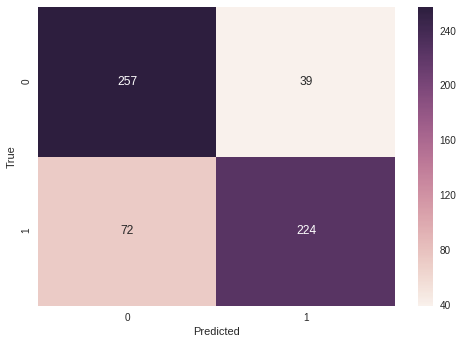

In [30]:
evaluate.plot_cm()

### Finally making the predictions for the evaluation data

In [31]:
eval_embeddings = fetch_embeddings(x_eval.values)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0410 16:19:33.562204 139790294316928 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [0]:
eval_predicts = model.predict(eval_embeddings)
eval_preds = np.argmax(eval_predicts, axis=1)

### adding the predicts to the evaluation dataframe

In [0]:
evaluation[2] = eval_preds

In [34]:
evaluation[2].value_counts()

0    758
1     75
Name: 2, dtype: int64

#### Converting the predictions to CSV

In [0]:
evaluation.to_csv('achintya_shankhdhar.csv')

In [0]:
from google.colab import files

In [0]:
files.download('achintya_shankhdhar.csv')

### Another possible approach

One can use Recurrent Neural Networks instead of using conventional dense network, since it has been seen that RNNs have performed well when it comes to text data.